# ECP Pre-processing
**Purpose: Convert raw ECP data to YOLO and COCO label formats**</br>
**Final Project**</br>
**Group 1**</br>
**DS6050 Deep Learning**</br>
**Fall 2023**</br>

In [76]:
%pip install pylabel pyyaml -q -U

Note: you may need to restart the kernel to use updated packages.


In [91]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from concurrent.futures import ThreadPoolExecutor
import matplotlib.patches as patches
from tqdm import tqdm
import shutil
from PIL import Image
from PIL import ImageDraw
import cv2
import numpy as np
from pycocotools.coco import COCO

## Download Data
Download the raw ECP data from the following link: https://eurocity-dataset.tudelft.nl/eval/user/login?_next=/eval/downloads/detection. Make sure the data is all in the same folder.

## Unzip Data

Execute `unzip` on each ECP zipfile. The data should unpack as follows:

```
ECP/
  day/
    img/
      val/
      train/
      test/
    labels/
      train/
      val/
  night/
    img/
      val/
      train/
      test/
    labels/
      train/
      val/
```

In [2]:
# Function to recursively search for JSON files
def find_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

## Get Label Categories

In [59]:
# Define the main folder path
folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP'

# Get a list of JSON files in subfolders
json_files = find_json_files(folder_path)

identities = set()
identity_counter = {}  # Dictionary to store the counts of each identity

# Iterate over the JSON files and load their contents
background_images = []
for json_file in json_files:
    with open(json_file, 'r') as file:
        data = json.load(file)
        if len(data['children']) == 0:
            background_images.append(json_file)
        else:
            for item in data['children']:
                if item['identity']:
                    identity = item['identity']
                    identities.add(identity)
                    # Update the counter for this identity
                    if identity in identity_counter:
                        identity_counter[identity] += 1
                    else:
                        identity_counter[identity] = 1
                else:
                    print(f"Empty label found for {json_file}")
                    background_images.append(json_file) ## Only single label in entire set is background

identity_mapping = {value: index for index, value in enumerate(identities)}
identity_mapping

{'buggy-group': 0,
 'motorbike': 1,
 'person-group-far-away': 2,
 'motorbike-group': 3,
 'wheelchair-group': 4,
 'tricycle-group': 5,
 'pedestrian': 6,
 'rider+vehicle-group-far-away': 7,
 'scooter-group': 8,
 'bicycle-group': 9,
 'bicycle': 10,
 'rider': 11}

In [60]:
identity_counter

{'pedestrian': 157124,
 'person-group-far-away': 67310,
 'bicycle-group': 16750,
 'rider': 14021,
 'rider+vehicle-group-far-away': 1755,
 'wheelchair-group': 18,
 'scooter-group': 9359,
 'motorbike-group': 3369,
 'buggy-group': 911,
 'tricycle-group': 77,
 'motorbike': 10,
 'bicycle': 18}

In [62]:
print(f"No label background images {len(background_images)}")

No label background images 2841


In [52]:
!cat /scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/koeln/koeln_00321.json

{
 "tags": [], 
 "imageheight": 1024, 
 "imagewidth": 1920, 
 "children": [
  {
   "tags": [], 
   "x0": 0, 
   "y1": 0, 
   "y0": 0, 
   "x1": 0, 
   "children": [], 
   "identity": null
  }
 ], 
 "identity": "frame"
}

In [55]:
!cp /scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/koeln/koeln_00321.json .

In [ ]:
#Remove error in file

In [56]:
!cat koeln_00321.json

{
 "tags": [], 
 "imageheight": 1024, 
 "imagewidth": 1920, 
 "children": [], 
 "identity": "frame"
}

In [57]:
!cp koeln_00321.json /scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/koeln/koeln_00321.json

In [63]:
!cat /scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/koeln/koeln_00321.json

{
 "tags": [], 
 "imageheight": 1024, 
 "imagewidth": 1920, 
 "children": [], 
 "identity": "frame"
}

In [42]:
background_images[:1]

['/scratch/ybt7qf/ds6050-group1-project/ECP/day/labels/train/ljubljana/ljubljana_00159.json']

In [43]:
!cat /scratch/ybt7qf/ds6050-group1-project/ECP/day/labels/train/ljubljana/ljubljana_00159.json

{
 "tags": [], 
 "imageheight": 1024, 
 "imagewidth": 1920, 
 "children": [], 
 "identity": "frame"
}

In [74]:
## Rerun to get label categories if a file has changed

## Create YOLO Labels

In [64]:
# Function to normalize coordinates with the center as (x0, y0)
def normalize_coordinates(x0, y0, x1, y1, image_width, image_height):
    normalized_x0 = (x0 + (x1 - x0) / 2) / image_width
    normalized_y0 = (y0 + (y1 - y0) / 2) / image_height
    normalized_width = (x1 - x0) / image_width
    normalized_height = (y1 - y0) / image_height
    return normalized_x0, normalized_y0, normalized_width, normalized_height

base_dir = "/scratch/ybt7qf/ds6050-group1-project/"  # modify this as needed (keep / at end)
dirs = [
    ['ECP/day/labels/train/', 'datasets/eurocitypersonsdataset/labels/train/'],
    ['ECP/night/labels/train/', 'datasets/eurocitypersonsdataset/labels/train/'],
    ['ECP/day/labels/val/', 'datasets/eurocitypersonsdataset/labels/val/'],
    ['ECP/night/labels/val/', 'datasets/eurocitypersonsdataset/labels/val/'],
]

for d in dirs:
    main_folder_path, save_dir = base_dir + d[0], base_dir + d[1]

    json_files = find_json_files(main_folder_path)

    os.makedirs(save_dir, exist_ok=True)

    # Iterate over subfolders and process JSON files
    for json_file in json_files:
        # Get the base name (with extension)
        base_name = os.path.basename(json_file)

        # Get the file name without extension
        file_name_without_extension = os.path.splitext(base_name)[0]

        with open(json_file, 'r') as file:
            data = json.load(file)

        children = data.get('children', [])
        with open(save_dir + f"{file_name_without_extension}.txt", 'w') as txt_file:
            for child in children:
                identity = child.get('identity', None)
                if identity:
                    identity_index = identity_mapping[identity]
                    x0, y0, x1, y1 = child['x0'], child['y0'], child['x1'], child['y1']
                    normalized_x0, normalized_y0, normalized_width, normalized_height = normalize_coordinates(
                        x0, y0, x1, y1, data['imagewidth'], data['imageheight']
                    )

                    # Save data in the text file
                    txt_file.write(f"{identity_index} {normalized_x0} {normalized_y0} {normalized_width} {normalized_height}\n")
                else:
                    print(f"no labels for {json_file}")
print("Processing completed.")

Processing completed.


## Copy Images to Dataset Directory

In [102]:
base_dir = "/scratch/ybt7qf/ds6050-group1-project/" # modify this as needed (keep / at end)
dirs = [
    ['ECP/day/img/train/', 'datasets/eurocitypersonsdataset/images/train/'],
    ['ECP/night/img/train/', 'datasets/eurocitypersonsdataset/images/train/'],
    ['ECP/day/img/val/', 'datasets/eurocitypersonsdataset/images/val/'],
    ['ECP/night/img/val/', 'datasets/eurocitypersonsdataset/images/val/'],
]

for d in dirs:
    source_folder, destination_folder = base_dir+d[0], base_dir+d[1]

    os.makedirs(destination_folder, exist_ok=True)

    # Loop over all subfolders and move .png files
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.endswith('.png'):
                source_file = os.path.join(root, file)
                destination_file = os.path.join(destination_folder, file)

                # Create the destination folder if it doesn't exist
                os.makedirs(os.path.dirname(destination_file), exist_ok=True)

                # Copy the .png file to the destination folder
                shutil.copy(source_file, destination_file)

print("PNG files copied to the destination folder.")

PNG files copied to the destination folder.


## Validate YOLO Labels

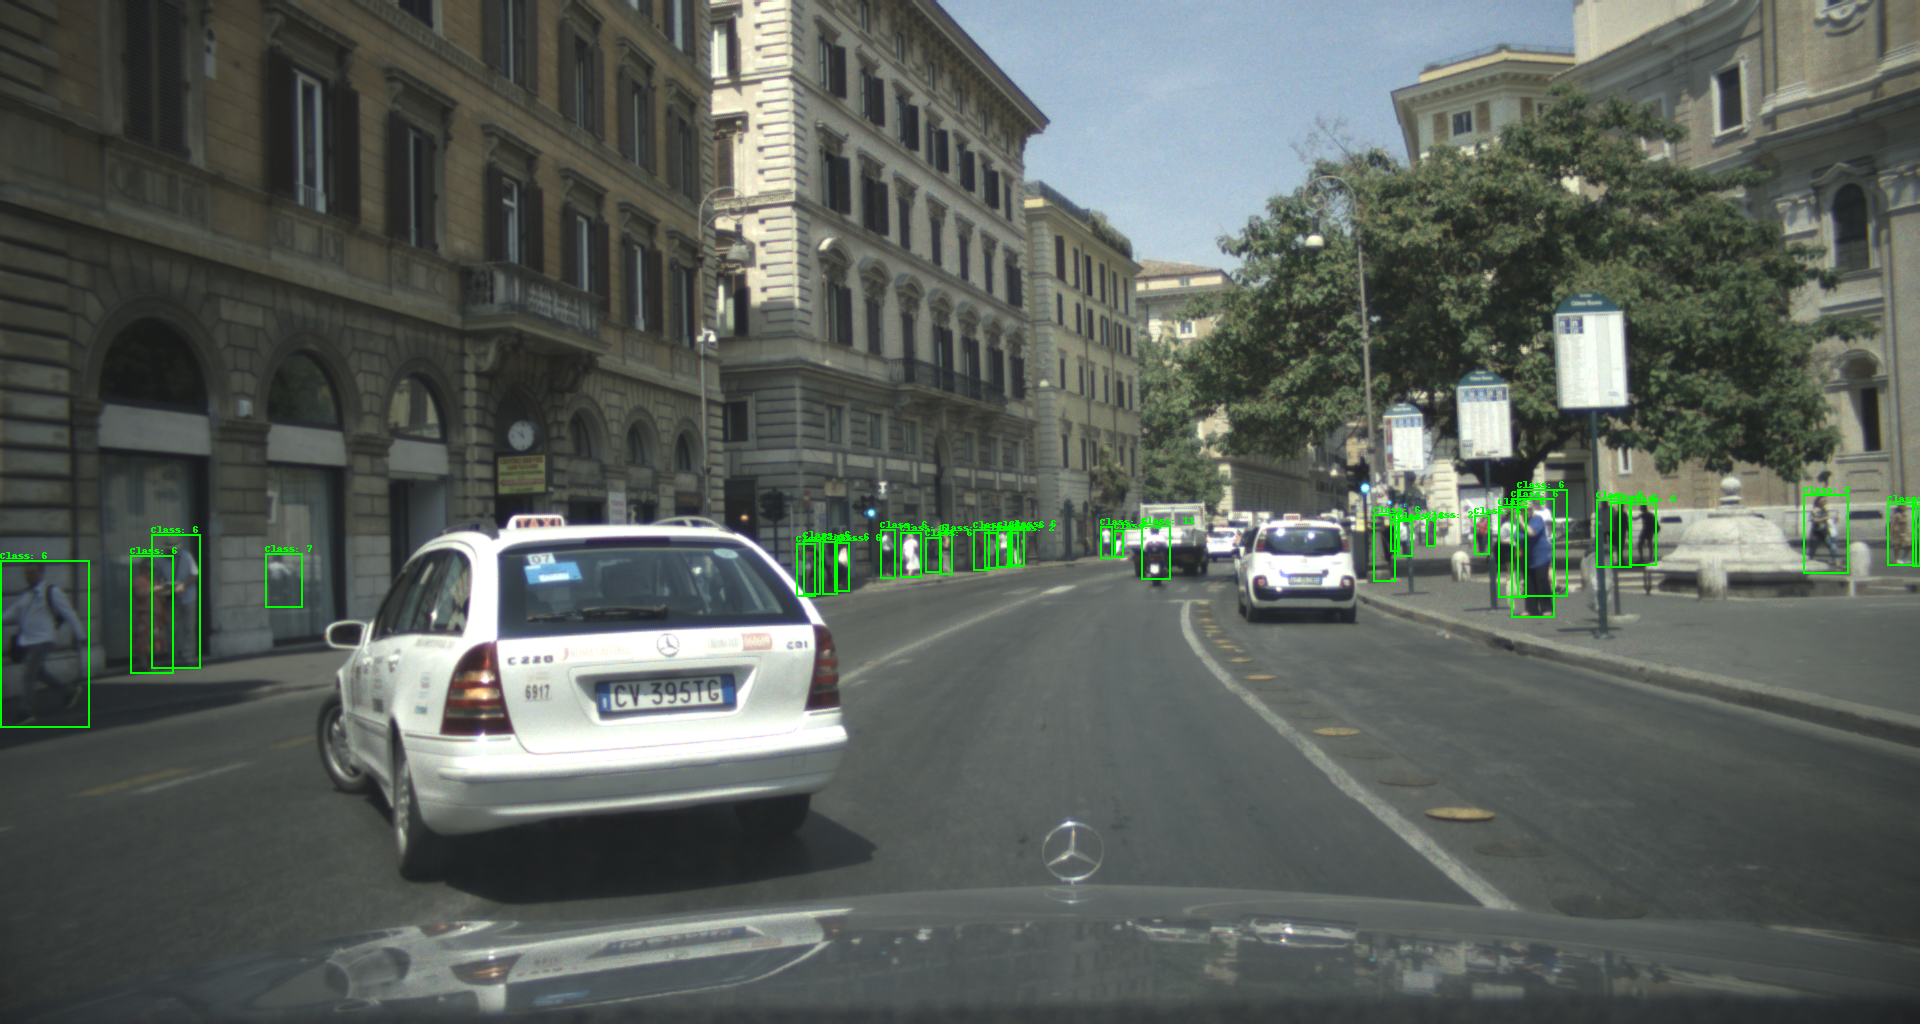

In [65]:
# Path to the YOLOv5 labels file
labels_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train/roma_00884.txt'

# Path to the image corresponding to the labels
image_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/roma_00884.png'

# Load the image
image = Image.open(image_path)

# Read the YOLOv5 labels file
with open(labels_path, 'r') as file:
    labels = file.read().strip().split('\n')

draw = ImageDraw.Draw(image)

for label in labels:
    parts = label.split()
    class_id = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO format to image coordinates
    x, y, w, h = int((x_center - width / 2) * image.width), int((y_center - height / 2) * image.height), int(width * image.width), int(height * image.height)
    
    # Define a color for the bounding box (RGB format)
    color = (0, 255, 0)  # Green
    
    # Draw the bounding box on the image
    draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
    
    # Display the class label on the image
    label_text = f'Class: {class_id}'
    draw.text((x, y - 10), label_text, fill=color)

# Display the image with bounding boxes
image

## Resize Images

In [130]:
# from concurrent.futures import ThreadPoolExecutor
# from PIL import Image
# import os
# from tqdm import tqdm

# image_source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/'
# label_source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train/'
# image_destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/'
# label_destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/'

# os.makedirs(image_destination_folder, exist_ok=True)
# os.makedirs(label_destination_folder, exist_ok=True)

# desired_width = 640

# def resize_image(image_path):
#     with Image.open(image_path) as img:
#         w, h = img.size
#         new_height = int((desired_width / w) * h)
#         img_resized = img.resize((desired_width, new_height), Image.ANTIALIAS)
#         destination_image_path = os.path.join(image_destination_folder, os.path.basename(image_path))
#         print(destination_image_path)
#         img_resized.save(destination_image_path, quality=90)  # Adjust quality as needed

#         # Load the corresponding YOLO text file and update the bounding box coordinates
#         yolo_txt_file = os.path.join(label_source_folder, os.path.basename(os.path.splitext(image_path)[0] + '.txt'))
#         destination_label_path = os.path.join(label_destination_folder, os.path.basename(os.path.splitext(image_path)[0] + '.txt'))

#         if os.path.exists(yolo_txt_file):
#             with open(yolo_txt_file, 'r') as file:
#                 lines = file.readlines()
#             print(destination_label_path)
#             with open(destination_label_path, 'w') as file:
#                 for line in lines:
#                     parts = line.strip().split()
#                     if len(parts) == 5:  # Check if the line has YOLO format
#                         class_id, x_center, y_center, width, height = map(float, parts)
                        
#                         # Calculate the scale factors for resizing
#                         x_scale = desired_width / w
#                         y_scale = new_height / h
                        
#                         # Scale the coordinates based on the resizing
#                         x_center *= x_scale
#                         y_center *= y_scale
#                         width *= x_scale
#                         height *= y_scale
                        
#                         file.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")

# # Get a list of image files
# # image_files = [os.path.join(image_source_folder, filename) for filename in os.listdir(image_source_folder) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]
# image_files = ["/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/dresden_00653.png"]

# # Using a thread pool for concurrent resizing
# with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust max_workers as needed
#     list(tqdm(executor.map(resize_image, image_files), total=len(image_files), desc="Resizing images and labels"))

# print("Images resized and YOLO labels updated to match the resized images.")

In [66]:
source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/'
# source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val/'

destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/'
# destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/'

os.makedirs(destination_folder, exist_ok=True)

desired_width = 1028

def resize_image(image_path):
    with Image.open(image_path) as img:
        w, h = img.size
        new_height = int((desired_width / w) * h)
        img_resized = img.resize((desired_width, new_height), Image.ANTIALIAS)
        destination_path = os.path.join(destination_folder, os.path.basename(image_path))
        img_resized.save(destination_path, quality=90)  # Adjust quality as needed

# Get a list of image files
image_files = [os.path.join(source_folder, filename) for filename in os.listdir(source_folder) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]

# Using a thread pool for concurrent resizing
with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust max_workers as needed
    list(tqdm(executor.map(resize_image, image_files), total=len(image_files), desc="Resizing images"))

print("Images resized and saved to the destination folder.")

Resizing images: 100%|██████████| 28114/28114 [11:44<00:00, 39.91it/s]

Images resized and saved to the destination folder.


In [182]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/

In [67]:
!find /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train/ \
    -type f -exec cp {} /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize \;

In [185]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val-resize/

In [68]:
!find /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val/ \
    -type f -exec cp {} /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val-resize \;

## Validate Labels on Resized Images

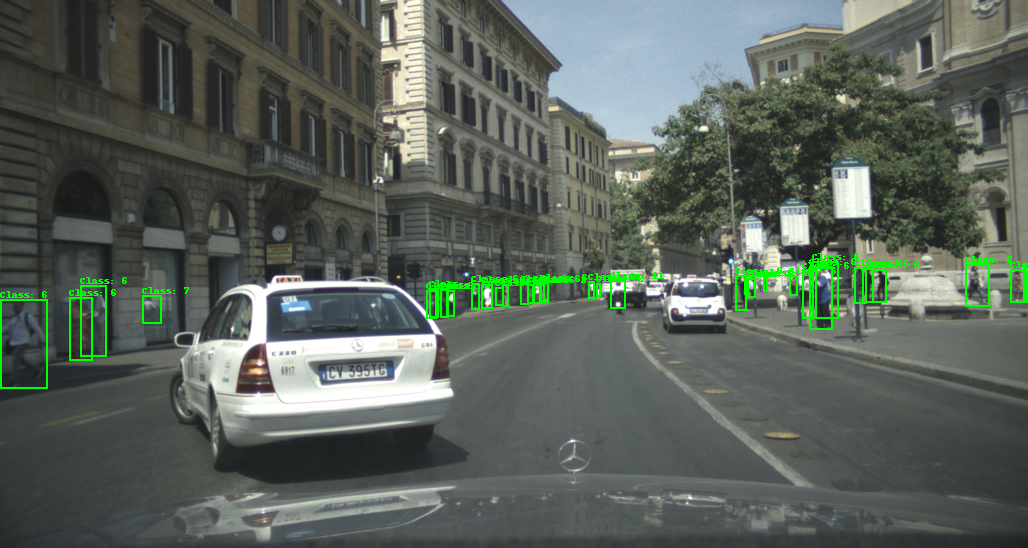

In [147]:
# Path to the YOLOv5 labels file
labels_path = "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/roma_00884.txt"

# Path to the image corresponding to the labels
image_path = "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/roma_00884.png"

# Load the image
image = Image.open(image_path)

# Read the YOLOv5 labels file
with open(labels_path, 'r') as file:
    labels = file.read().strip().split('\n')

draw = ImageDraw.Draw(image)

for label in labels:
    parts = label.split()
    class_id = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO format to image coordinates
    x, y, w, h = int((x_center - width / 2) * image.width), int((y_center - height / 2) * image.height), int(width * image.width), int(height * image.height)
    
    # Define a color for the bounding box (RGB format)
    color = (0, 255, 0)  # Green
    
    # Draw the bounding box on the image
    draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
    
    # Display the class label on the image
    label_text = f'Class: {class_id}'
    draw.text((x, y - 10), label_text, fill=color)

# Display the image with bounding boxes
image

## Create YOLO Yaml

In [72]:
%%writefile /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml
path: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset
train: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize
val: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize
    
nc: 12
    
names: [
    'buggy-group',
    'motorbike',
    'person-group-far-away',
    'motorbike-group',
    'wheelchair-group',
    'tricycle-group',
    'pedestrian',
    'rider+vehicle-group-far-away',
    'scooter-group',
    'bicycle-group',
    'bicycle',
    'rider'
]

Overwriting /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml


In [73]:
!cat /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml

path: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset
train: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize
val: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize
    
nc: 12
    
names: [
    'buggy-group',
    'motorbike',
    'person-group-far-away',
    'motorbike-group',
    'wheelchair-group',
    'tricycle-group',
    'pedestrian',
    'rider+vehicle-group-far-away',
    'scooter-group',
    'bicycle-group',
    'bicycle',
    'rider'
]


## Convert Training and Validation Labels to COCO Format

In [157]:
import json

# Define the paths to YOLO labels, the images directory, and the output COCO JSON file
# Train
# yolo_labels_directory = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/'   # Directory containing YOLO labels
# images_directory = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/'             # Directory containing the images
# coco_image_directory = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017'
# coco_json_path = 'custom_train.json'     # Output COCO JSON file

# Val
yolo_labels_directory = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val-resize/'   # Directory containing YOLO labels
images_directory = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/'             # Directory containing the images
coco_image_directory = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/val2017'
coco_json_path = 'custom_val.json'     # Output COCO JSON file

# Define the class mapping between YOLO classes and COCO categories
class_mapping = identity_mapping #{value: key for key, value in identity_mapping.items()}

# Initialize COCO data structures with empty "license" and "info" keys
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [],
    "licenses": [],  # Add an empty list for licenses
    "info": {}  # Add an empty dictionary for info
}

# Initialize image_id
image_id = 0

# Loop through YOLO labels and images to convert to COCO format
for yolo_label_file in os.listdir(yolo_labels_directory):
    if yolo_label_file.endswith('.txt'):
        image_filename = os.path.splitext(yolo_label_file)[0] + '.png'  # Assuming image extensions are .jpg

        # Load the image to get its width and height
        image_path = os.path.join(images_directory, image_filename)
        image = Image.open(image_path)
        image_width, image_height = image.size

        # Increment image_id
        image_id += 1

        # Read YOLO labels and convert to COCO format
        with open(os.path.join(yolo_labels_directory, yolo_label_file), 'r') as yolo_file:
            for line in yolo_file:
                data = line.strip().split()

                # Extract information from YOLO label
                class_index = int(data[0])
                x_normalized, y_normalized, width_normalized, height_normalized = map(float, data[1:5])

                # Map YOLO class to COCO category
                category_id = class_index #class_mapping.get(class_index)

                # Convert normalized coordinates to pixel values
                x_center = int(x_normalized * image_width)
                y_center = int(y_normalized * image_height)
                width_pixel = int(width_normalized * image_width)
                height_pixel = int(height_normalized * image_height)

                # Calculate top-left corner coordinates
                x_pixel = x_center - (width_pixel // 2)
                y_pixel = y_center - (height_pixel // 2)
                
                # Create COCO annotation
                annotation = {
                    "id": len(coco_data["annotations"]) + 1,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [x_pixel, y_pixel, width_pixel, height_pixel],
                    "area": width_pixel * height_pixel,
                    "iscrowd": 0,
                    "segmentation": []
                }

                coco_data["annotations"].append(annotation)

        # Create COCO categories (if not already created)
        for class_name, category_id in class_mapping.items():
            category = {
                "id": category_id,
                "name": class_name,
                "supercategory": class_name
            }
            if category not in coco_data["categories"]:
                coco_data["categories"].append(category)

        # Create COCO image data with the "folder" key
        image_data = {
            "id": image_id,
            "file_name": image_filename,
            "width": image_width,
            "height": image_height,
            "folder": coco_image_directory
        }
        coco_data["images"].append(image_data)

# Save the COCO data as a JSON file
with open(coco_json_path, 'w') as coco_file:
    json.dump(coco_data, coco_file, indent=4)

print(f"COCO JSON data has been saved to {coco_json_path}")

COCO JSON data has been saved to custom_val.json


In [ ]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/

In [158]:
!mv custom_train.json /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/custom_train.json

In [159]:
!mv custom_val.json /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/custom_val.json

In [107]:
!ls /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations

custom_train.json  custom_val.json


## Move Images for COCO Structure

In [110]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017

In [111]:
!find /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/ \
    -type f -exec cp {} /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017/ \;

In [151]:
ls -l /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/ | grep "^-" | wc -l

28114


In [152]:
ls -l /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017/ | grep "^-" | wc -l

28114


In [112]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/val2017

In [113]:
!find /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/ \
    -type f -exec cp {} /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/val2017/ \;

In [153]:
ls -l /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/ | grep "^-" | wc -l

5036


In [154]:
ls -l /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/val2017/ | grep "^-" | wc -l

5036


## Validate COCO Labels

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/train2017/ljubljana_00730.png


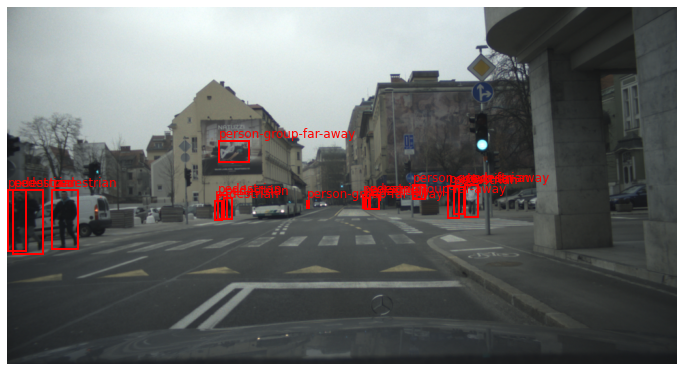

In [163]:
# Load the COCO dataset annotations file and the corresponding image
coco = COCO('/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/annotations/custom_train.json')  # Replace 'annotations_file.json' with your JSON annotations file
image_id = 1000  # Replace with the desired image ID
image_info = coco.loadImgs(image_id)[0]
image_path = image_info['folder']+"/"+image_info['file_name']  # Replace with the path to your image
print(image_path)

# Load the image
image = plt.imread(image_path)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, figsize=(12, 9))

# Display the image
ax.imshow(image)

# Load annotations for the selected image
ann_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(ann_ids)

# Loop through annotations and plot bounding boxes
for annotation in annotations:
    bbox = annotation['bbox']
    category_id = annotation['category_id']
    category = coco.loadCats(category_id)[0]['name']

    # Extract the (x, y) coordinates and dimensions of the bounding box
    x, y, width, height = bbox
    x, y, width, height = int(x), int(y), int(width), int(height)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the Rectangle patch to the axis
    ax.add_patch(rect)

    # Display the category label near the bounding box
    plt.text(x, y - 5, f'{category}', color='red', fontsize=12)

# Hide axis labels and ticks
ax.axis('off')

# Show the image with annotations
plt.show()